# Logistic Regression with Mini-Batch Gradient Descent using TensorFlow

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
import os
from IPython.display import Image
from IPython.core.display import HTML 
from IPython.display import SVG, display

In [2]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
N = 1000
X, y = make_moons(N, noise=0.1, random_state=42)

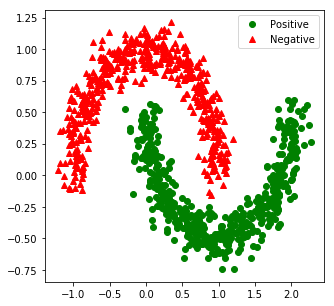

In [4]:
plt.figure(figsize=(5,5))
plt.plot(X[y == 1, 0], X[y == 1, 1], 'go', label="Positive")
plt.plot(X[y == 0, 0], X[y == 0, 1], 'r^', label="Negative")
plt.legend()
plt.show()

In [5]:
m, n = X.shape
X_plus_bias = np.c_[np.ones((m, 1)), X]

y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X_plus_bias, y, test_size=0.2, random_state=42)

In [6]:
n_epochs = 10001
batch_size = 50
n_batches = int(np.ceil(m / batch_size))
learning_rate = 0.01

def log_dir(prefix="", root_logdir = "tf2_logs"):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

def fetch_batch(X_train, y_train, epoch, batch_index, batch_size):
    m, n = X_train.shape
    np.random.seed(epoch * n_batches + batch_index)
    indices = np.random.randint(m, size=batch_size)
    X_batch = X_train[indices]
    y_batch = y_train[indices]
    return X_batch, y_batch

def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    with tf.name_scope("logistic_regression"):
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('log_loss', loss)
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
        with tf.name_scope("save"):
            saver = tf.train.Saver()

    return y_proba, loss, training_op, loss_summary, init, saver

In [7]:
reset_graph()

n_inputs = 2
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(X_train, y_train, epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})
    os.remove(checkpoint_epoch_path)

Training was interrupted. Continuing at epoch 10001
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/my_logreg_model.ckpt


InvalidArgumentError: Restoring from checkpoint failed. This is most likely due to a mismatch between the current graph and the graph from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

Assign requires shapes of both tensors to match. lhs shape= [3,1] rhs shape= [7,1]
	 [[node logistic_regression/save/save/Assign (defined at <ipython-input-6-33286d7fbd4a>:38) ]]

Errors may have originated from an input operation.
Input Source operations connected to node logistic_regression/save/save/Assign:
 logistic_regression/model/theta (defined at <ipython-input-6-33286d7fbd4a>:27)

Original stack trace for 'logistic_regression/save/save/Assign':
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\ProgramData\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 539, in run_forever
    self._run_once()
  File "C:\ProgramData\Anaconda3\lib\asyncio\base_events.py", line 1775, in _run_once
    handle._run()
  File "C:\ProgramData\Anaconda3\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 781, in inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 225, in wrapper
    runner = Runner(result, future, yielded)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 708, in __init__
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\ProgramData\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-240a9109f76a>", line 9, in <module>
    y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)
  File "<ipython-input-6-33286d7fbd4a>", line 38, in logistic_regression
    saver = tf.train.Saver()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 825, in __init__
    self.build()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 837, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 875, in _build
    build_restore=build_restore)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 508, in _build_internal
    restore_sequentially, reshape)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 350, in _AddRestoreOps
    assign_ops.append(saveable.restore(saveable_tensors, shapes))
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saving\saveable_object_util.py", line 72, in restore
    self.op.get_shape().is_fully_defined())
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\state_ops.py", line 227, in assign
    validate_shape=validate_shape)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 65, in assign
    use_locking=use_locking, name=name)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
y_pred = (y_proba_val >= 0.5)

In [ ]:
precision_score(y_test, y_pred)

In [ ]:
recall_score(y_test, y_pred)

In [ ]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector

plt.figure(figsize=(5,5))
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

Esse resultado parece muito ruim, não é? Mas não vamos esquecer que o modelo de Regressão Logística tem um limiar de decisão linear, portanto, esse é realmente o melhor que podemos fazer com esse modelo (a menos que adicionemos mais atributos, como mostraremos em um segundo).

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
#%reload_ext tensorboard

In [ ]:
tensorboard --logdir tf2_logs --host localhost

In [ ]:
Image(filename='graph_mini_batch.png')

In [ ]:
display(SVG(filename='logistic_regression_1_train_log_loss.svg'))

# Higher order hypothesis

In [9]:
X_train_enhanced = np.c_[X_train,
                         X_train[:, 1] ** 2,
                         X_train[:, 2] ** 2,
                         X_train[:, 1] ** 3,
                         X_train[:, 2] ** 3]
X_test_enhanced = np.c_[X_test,
                        X_test[:, 1] ** 2,
                        X_test[:, 2] ** 2,
                        X_test[:, 1] ** 3,
                        X_test[:, 2] ** 3]

In [10]:
reset_graph()

n_inputs = 6
logdir = log_dir('logreg3', 'tf3_logs')

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [11]:
checkpoint_path = "/tmp/my_logreg3_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model3"

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(X_train_enhanced, y_train, epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test_enhanced, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test_enhanced, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 0.63565993
Epoch: 500 	Loss: 0.14826326
Epoch: 1000 	Loss: 0.10515868
Epoch: 1500 	Loss: 0.083768435
Epoch: 2000 	Loss: 0.07067697
Epoch: 2500 	Loss: 0.061872102
Epoch: 3000 	Loss: 0.05539835
Epoch: 3500 	Loss: 0.05038188
Epoch: 4000 	Loss: 0.046481315
Epoch: 4500 	Loss: 0.04330194
Epoch: 5000 	Loss: 0.040513963
Epoch: 5500 	Loss: 0.038281865
Epoch: 6000 	Loss: 0.036329266
Epoch: 6500 	Loss: 0.03461602
Epoch: 7000 	Loss: 0.033127416
Epoch: 7500 	Loss: 0.03173547
Epoch: 8000 	Loss: 0.030551987
Epoch: 8500 	Loss: 0.029489698
Epoch: 9000 	Loss: 0.028479481
Epoch: 9500 	Loss: 0.027515955
Epoch: 10000 	Loss: 0.026656229


In [12]:
y_pred = (y_proba_val >= 0.5)

In [13]:
precision_score(y_test, y_pred)

1.0

In [14]:
recall_score(y_test, y_pred)

0.99

In [18]:
y_pred_idx = y_pred.reshape(-1) # a 1D array rather than a column vector

plt.figure(figsize=(5,5))
plt.plot(X_test[y_pred_idx, 1], X_test[y_pred_idx, 2], 'go', label="Positive")
plt.plot(X_test[~y_pred_idx, 1], X_test[~y_pred_idx, 2], 'r^', label="Negative")
plt.legend()
plt.show()

NameError: name 'ypred' is not defined

In [16]:
%tensorboard --logdir tf3_logs --host localhost

UsageError: Line magic function `%tensorboard` not found.
